In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ssm 
from tqdm import tqdm

/Users/thomasbush/miniconda3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
csv_all_path = Path("/Users/thomasbush/Downloads/features_all.csv")
csv_all_path_td_1 = Path("/Users/thomasbush/Downloads/features_all_dt0.100.csv")
csv_all_features_150_path = Path("/Users/thomasbush/Downloads/features_all_dt0.150.csv")
df_all = pd.read_csv(csv_all_features_150_path)

In [42]:
# try to fit a model with the known features multi-mice
FEAT_4 = [
    "dist_head_z",
    "head_speed_z",
    "head_acc",
    "facing_angle_sin_z",
    "facing_angle_cos_z",
    "radial_vel_z",
    'forepawL_tail_distance_z',
    'forepawR_tail_distance_z',
    'angle_head_body_r_sin_z', 
    'angle_head_body_r_cos_z',
    'angle_head_body_l_sin_z', 
    'angle_head_body_l_cos_z',
]

sequences = []
metas = []

# ensure correct ordering
df_all_sorted = df_all.sort_values(["mouse", "condition", "session", "time"])

for (mouse, condition, session), df_sess in df_all_sorted.groupby(["mouse", "condition", "session"]):
    X = df_sess[FEAT_4].values.astype(float)  # shape (T, 4)
    if len(X) < 10:
        continue  # skip tiny sequences just in case

    sequences.append(X)
    metas.append({
        "mouse": mouse,
        "condition": condition,
        "session": session,
        "file": df_sess["file"].iloc[0],
    })

print(f"Built {len(sequences)} sequences")
print("Example sequence shape:", sequences[0].shape)

Built 36 sequences
Example sequence shape: (9138, 12)


In [43]:
K = 8
D = len(FEAT_4)

hmm = ssm.HMM(
    K=K,
    D=D,
    transitions="sticky",
    transition_kwargs=dict(kappa=50.0),
    observations="gaussian",
)

lls = hmm.fit(
    sequences,
    method="em",
    num_iters=100,
    init_method="kmeans",
    verbose=True,
)

print("Model fitted")
print("Final log-likelihood:", lls[-1])

Model fitted
Final log-likelihood: -4371490.812126545


In [30]:
K = 5
D = len(FEAT_4)      # observation dimensionality
lags = 2             # number of AR lags (choose 1, 2, 3, ...)

# sequences should be: list of arrays, each of shape (T_i, D)
# e.g. sequences = [seq1, seq2, ...] where seq1.shape == (T1, D)

hmm = ssm.HMM(
    K=K,
    D=D,
    M=0,                        # no exogenous inputs
    transitions="sticky",
    transition_kwargs=dict(kappa=50.0),
    observations="ar",
    observation_kwargs=dict(
        lags=lags,
        # optional: small prior to regularize AR weights
        # sigma0=1.0,
    ),
)

lls = hmm.fit(
    sequences,
    method="em",
    num_iters=100,
    init_method="kmeans",
    verbose=True,
)

print("Model fitted")
print("Final log-likelihood:", lls[-1])

Model fitted
Final log-likelihood: -2534957.9111234057


In [44]:
state_seqs = [hmm.most_likely_states(seq) for seq in sequences]

# quick sanity: dwell times
def dwell_times(z):
    durs = []
    cur = z[0]
    run = 1
    for s in z[1:]:
        if s == cur:
            run += 1
        else:
            durs.append(run)
            cur = s
            run = 1
    durs.append(run)
    return np.array(durs)

all_durs = np.concatenate([dwell_times(z) for z in state_seqs])
print("Median dwell (steps):", np.median(all_durs))
print("Median dwell (s):", np.median(all_durs) * 0.15)

Median dwell (steps): 3.0
Median dwell (s): 0.44999999999999996


In [45]:
rows = []

for seq, z, meta in zip(sequences, state_seqs, metas):
    T = len(z)
    df_tmp = pd.DataFrame(seq, columns=FEAT_4)
    df_tmp["state"] = z
    df_tmp["time"] = np.arange(T) * 0.15  # seconds

    for k, v in meta.items():
        df_tmp[k] = v

    rows.append(df_tmp)

df_states_4feat = pd.concat(rows, ignore_index=True)
print(df_states_4feat.head())

   dist_head_z  head_speed_z   head_acc  facing_angle_sin_z  \
0    -0.411107     -0.508038  16.239761           -0.632820   
1    -0.436295     -0.433811   4.147652           -0.627120   
2    -0.451057     -0.436018  36.898040           -0.629691   
3    -0.463543     -0.153388  43.312981           -0.627846   
4    -0.501012     -0.135639  35.528170           -0.625054   

   facing_angle_cos_z  radial_vel_z  forepawL_tail_distance_z  \
0            1.031568     -0.030025                 -0.675439   
1            1.032894     -0.114565                 -0.662770   
2            1.032312      0.185704                 -0.706240   
3            1.032678     -0.005051                 -0.695842   
4            1.033298      0.067241                 -0.667214   

   forepawR_tail_distance_z  angle_head_body_r_sin_z  angle_head_body_r_cos_z  \
0                  0.196241                -0.497559                -0.031776   
1                  0.179008                -0.529619                

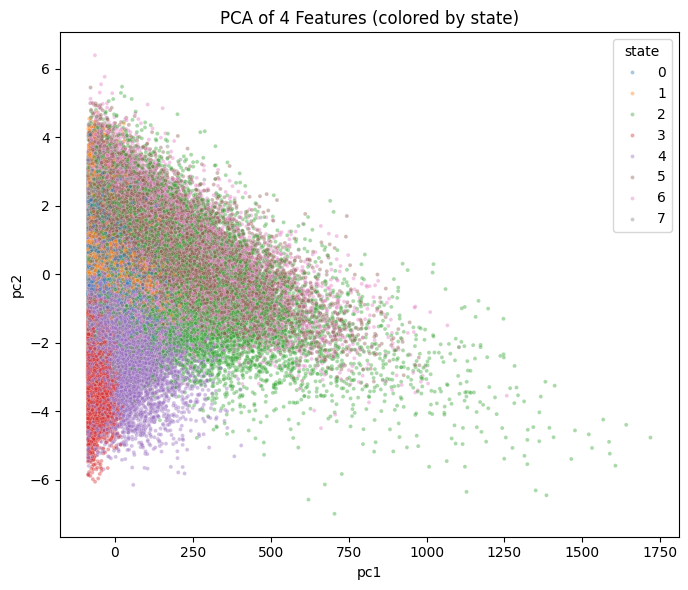

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

FEAT_4 = [
    "dist_head_z",
    "head_speed_z",
    "head_acc",
    "facing_angle_sin_z",
    "facing_angle_cos_z",
    "radial_vel_z",
    'forepawL_tail_distance_z',
    'forepawR_tail_distance_z',
    'angle_head_body_r_sin_z', 
    'angle_head_body_r_cos_z',
    'angle_head_body_l_sin_z', 
    'angle_head_body_l_cos_z',
]

X = df_states_4feat[FEAT_4].values
pca = PCA(n_components=2)
df_states_4feat["pc1"], df_states_4feat["pc2"] = pca.fit_transform(X).T

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df_states_4feat,
    x="pc1", y="pc2",
    hue="state",
    palette="tab10",
    s=8, alpha=0.4
)
plt.title("PCA of 4 Features (colored by state)")
plt.tight_layout()
plt.show()


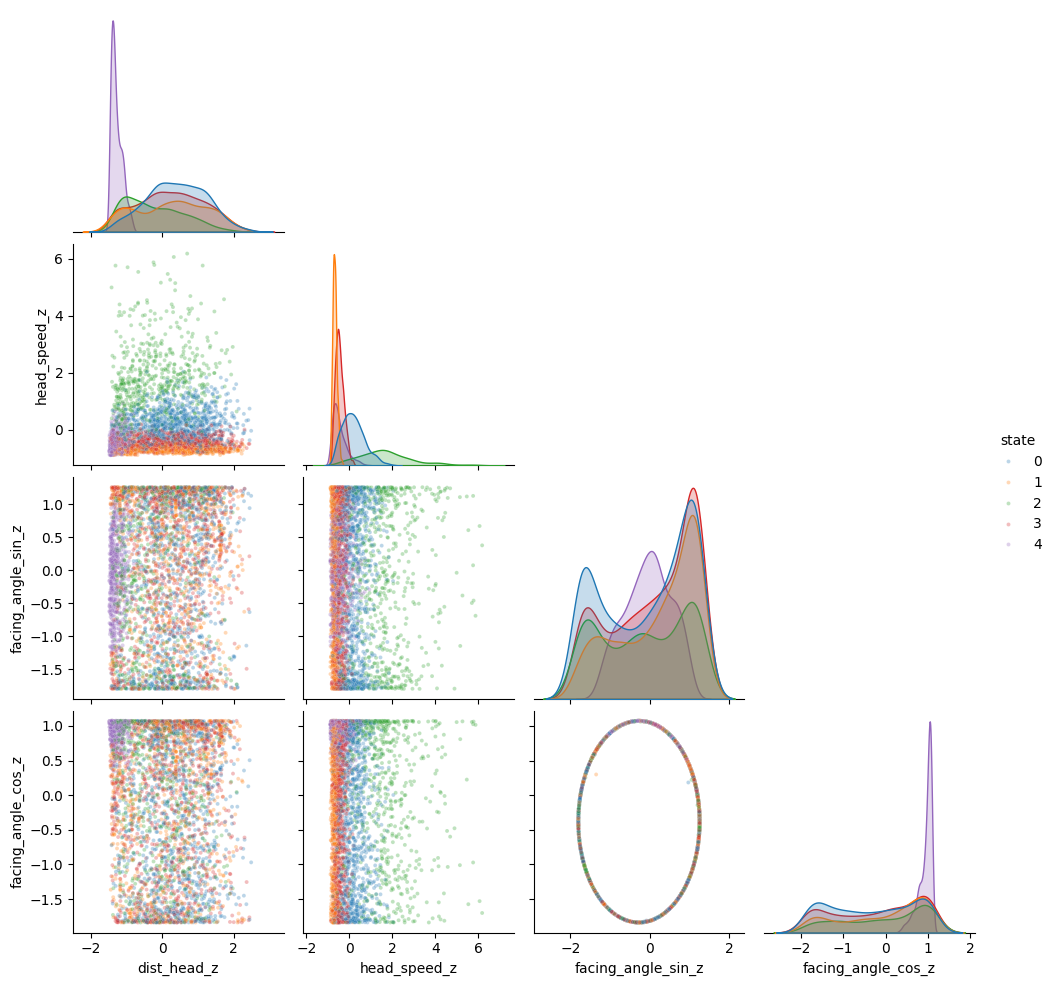

In [38]:
sns.pairplot(
    df_states_4feat.sample(4000),
    vars=["dist_head_z", "head_speed_z", "facing_angle_sin_z", "facing_angle_cos_z"],
    hue="state",
    corner=True,
    plot_kws=dict(s=8, alpha=0.3), 
    palette="tab10"
)
plt.show()
